In [8]:
%run ./work/Config.ipynb

In [9]:
# Function definitions for the rest of the workbook
from chart_studio import plotly as py
import chart_studio.tools as tls

def columns():
    return(['food_code', 'food_desc', 'food_group_code', 'food_group_desc',
    'is_animal', 'is_fruit', 'is_vegetable', 'is_dairy', 'is_white_meat',
    'is_red_meat', 'is_nut_or_seed', 'is_legume', 'glycemic_class', 'glycemic_index',
    'pct_water', 'pct_procnt', 'pct_chocdf', 'pct_fibtg', 'pct_ca', 'pct_fe', 'pct_mg', 'pct_p',
    'pct_k', 'pct_na', 'pct_zn', 'pct_cu', 'pct_mn', 'pct_se', 'pct_vitc', 'pct_thia', 'pct_ribf',
    'pct_nia', 'pct_vitb6a', 'pct_fol', 'pct_choln', 'pct_vitb12', 'pct_vita_rae', 'pct_tocpha',
    'pct_vitd', 'pct_vitk1', 'pct_f18d2', 'pct_f18d3',])

def fndds_query():
    return("""SELECT
            food.food_code, main_food_description
            ,LEFT(food.food_code, 2) AS food_group_code
            ,food_coding_scheme.description
            ,LEFT(food.food_code, 2) IN (11, 12, 14, 20, 21, 22, 23, 24, 31, 32) AS is_animal
            ,LEFT(food.food_code, 2) IN (61, 62, 63) AS is_fruit
            ,LEFT(food.food_code, 2) IN (71, 72, 73, 74, 75) AS is_vegetable
            ,LEFT(food.food_code, 2) IN (11, 12, 14) AS is_dairy
            ,LEFT(food.food_code, 2) IN (22, 24) AS is_white_meat
            ,LEFT(food.food_code, 2) IN (21, 23) AS is_red_meat
            ,LEFT(food.food_code, 2) IN (42, 43) AS is_nut_or_seed
            ,LEFT(food.food_code, 2) IN (41) AS is_legume
            ,IF(glycemic_index <=56, 0, IF(glycemic_index <=71, 1, 2)) AS glycemic_class
            ,glycemic_index
            ,food.water/dri.water AS pct_water
            ,food.procnt/dri.procnt AS pct_procnt
            ,food.chocdf/dri.chocdf AS pct_chocdf
            ,food.fibtg/dri.fibtg AS pct_fibtg
            ,food.ca/dri.ca AS pct_ca
            ,food.fe/dri.fe AS pct_fe
            ,food.mg/dri.mg AS pct_mg
            ,food.p/dri.p AS pct_p
            ,food.k/dri.k AS pct_k
            ,food.na/dri.na AS pct_na
            ,food.zn/dri.zn AS pct_zn
            ,food.cu/dri.cu AS pct_cu
            ,food.mn/dri.mn AS pct_mn
            ,food.se/dri.se AS pct_se
            ,food.vitc/dri.vitc AS pct_vitc
            ,food.thia/dri.thia AS pct_thia
            ,food.ribf/dri.ribf AS pct_ribf
            ,food.nia/dri.nia AS pct_nia
            ,food.vitb6a/dri.vitb6a AS pct_vitb6a
            ,food.fol/dri.fol AS pct_fol
            ,food.choln/dri.choln AS pct_choln
            ,food.vitb12/dri.vitb12 AS pct_vitb12
            ,food.vita_rae/dri.vita_rae AS pct_vita_rae
            ,food.tocpha/dri.tocpha AS pct_tocpha
            ,food.vitd/dri.vitd AS pct_vitd
            ,food.vitk1/dri.vitk1 AS pct_vitk1
            ,food.f18d2/dri.f18d2 AS pct_f18d2
            ,food.f18d3/dri.f18d3 AS pct_f18d3
        FROM
            fndds.fndds_nut_val_flat AS food
            JOIN dietary_reference_intake.dietary_reference_intake_flat AS dri
            JOIN fndds.food_coding_scheme ON prefix = LEFT(food.food_code, 2)
            JOIN fndds.glycemic_index AS gi ON food.food_code = gi.food_code
        WHERE
            age_from = 31 AND sex = 'Male' AND type = 'recommended'
        ;""")

# Graph the results for selected food groups
def scatterplot_1d(data, mask):
    tls.set_credentials_file(username=PLOTLY_USER, api_key=PLOTLY_AUTH)
    
    traces = []
    #names = ['Vegetables', 'Fruits', 'Nuts, Seeds, and Legumes', 'Dairy', 'White Meat', 'Red Meat']
    #names = ['Plant', 'Animal']
    names = ['Low', 'Medium', 'High']

    for n in range(max(mask)+1):
        x = data[mask==n,0]
        y = np.full((1,len(x)), n).flatten()
        trace = Scatter(
            x=x,
            y=y,
            mode='markers',
            name=names[n],
            marker=Marker(
                size=12,
                line=Line(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5),
            opacity=0.5))
        traces.append(trace)

    MyLayout = Layout(xaxis=layout.XAxis(showline=False),
                    yaxis=layout.YAxis(showline=False))
    return Figure(data=traces, layout=MyLayout)

# Graph the given points, colored by label
def scatterplot_2d(data, labels):
    tls.set_credentials_file(username=PLOTLY_USER, api_key=PLOTLY_AUTH)
    
    traces = []
    names = list(set(labels))
    
    for name in names:
        x = data[labels==name,0]
        y = data[labels==name,1]
        trace = Scatter(
            x=x,
            y=y,
            mode='markers',
            name=name,
            marker=Marker(
                size=12,
                line=Line(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5),
            opacity=0.5))
        traces.append(trace)

    MyLayout = Layout(xaxis=layout.XAxis(showline=False),
                    yaxis=layout.YAxis(showline=False))
    return Figure(data=traces, layout=MyLayout)

# Draw a graph of the best decision tree
from sklearn.tree import export_graphviz
from IPython.display import display

# Export as dot file
def graph_tree(tree):
    export_graphviz(tree, out_file='tree.dot', 
                    feature_names = X.columns,
                    class_names = ['Low','Medium','High'],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, special_characters=True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # Display in jupyter notebook
    from IPython.display import Image
    return(Image(filename = 'tree.png'))

In [10]:
# Lookup food data from the DB
data = fetch_dataframe(fndds_query(), schema="fndds")
data = data.dropna()
data.columns = columns()

foods = data.iloc[:, 1]
X = data.loc[:, 'pct_ca':]
y = data.loc[:, 'glycemic_class']

print(X.shape)

(2405, 24)


In [11]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Convert the "glycemic_class" integer to text labels
names = ['Low', 'Medium', 'High']
labels = [names[i] for i in y]
labels = pd.Index(labels)

In [12]:
# Import Random Forest Model and the scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Create a Gaussian Classifier
forest=RandomForestClassifier(n_estimators=50, max_depth=2, max_leaf_nodes=None)

# Train the model using the training sets y_pred=clf.predict(X_test)
forest.fit(X_train,y_train)

# Make predictions for the test set
y_pred=forest.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:")
for i in [0, 1, 2]:
        print("\t%7s: %6.3f" % (names[i],100*metrics.accuracy_score(y_test[y_test==i], y_pred[y_test==i])))

# What are the relative importances of features?
feature_imp = pd.Series(forest.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

# Score the trees
trees = forest.estimators_
scores = ["%3.1f"% (100*metrics.accuracy_score(y_test, estimator.predict(X_test))) for estimator in trees]

# Sort them by rank
ranked = pd.concat((pd.DataFrame(trees),pd.DataFrame(scores)), axis=1)
ranked.columns = ['Tree', 'Score']
ranked.sort_values('Score', ascending=False, inplace=True)
ranked


Accuracy:
	    Low: 100.000
	 Medium:  0.000
	   High:  0.000


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without

Tree Score
49  DecisionTreeClassifier(max_depth=2, max_featur...  75.3
15  DecisionTreeClassifier(max_depth=2, max_featur...  74.4
13  DecisionTreeClassifier(max_depth=2, max_featur...  74.4
3   DecisionTreeClassifier(max_depth=2, max_featur...  74.1
8   DecisionTreeClassifier(max_depth=2, max_featur...  73.8
33  DecisionTreeClassifier(max_depth=2, max_featur...  73.8
40  DecisionTreeClassifier(max_depth=2, max_featur...  73.8
24  DecisionTreeClassifier(max_depth=2, max_featur...  73.5
1   DecisionTreeClassifier(max_depth=2, max_featur...  73.4
10  DecisionTreeClassifier(max_depth=2, max_featur...  73.3
29  DecisionTreeClassifier(max_depth=2, max_featur...  73.0
34  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
35  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
36  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
22  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
30  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
37  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
28  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
41  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
27  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
26  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
20  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
44  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
12  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
47  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
6   DecisionTreeClassifier(max_depth=2, max_featur...  72.6
7   DecisionTreeClassifier(max_depth=2, max_featur...  72.6
9   DecisionTreeClassifier(max_depth=2, max_featur...  72.6
11  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
39  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
14  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
17  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
45  DecisionTreeClassifier(max_depth=2, max_featur...  72.6
4   DecisionTreeClassifier(max_depth=2, max_featur...  72.3
19  DecisionTreeClassifier(max_depth=2, max_featur...  72.3
16  DecisionTreeClassifier(max_depth=2, max_featur...  71.7
31  DecisionTreeClassifier(max_depth=2, max_featur...  71.5
42  DecisionTreeClassifier(max_depth=2, max_featur...  70.9
5   DecisionTreeClassifier(max_depth=2, max_featur...  70.8
23  DecisionTreeClassifier(max_depth=2, max_featur...  70.6
0   DecisionTreeClassifier(max_depth=2, max_featur...  70.4
43  DecisionTreeClassifier(max_depth=2, max_featur...  69.8
32  DecisionTreeClassifier(max_depth=2, max_featur...  69.3
18  DecisionTreeClassifier(max_depth=2, max_featur...  69.3
2   DecisionTreeClassifier(max_depth=2, max_featur...  69.0
38  DecisionTreeClassifier(max_depth=2, max_featur...  68.8
46  DecisionTreeClassifier(max_depth=2, max_featur...  68.8
25  DecisionTreeClassifier(max_depth=2, max_featur...  68.4
48  DecisionTreeClassifier(max_depth=2, max_featur...  67.7
21  DecisionTreeClassifier(max_depth=2, max_featur...  67.6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


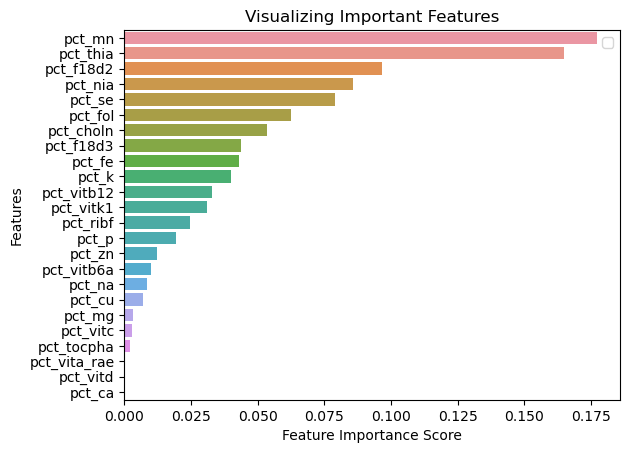

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

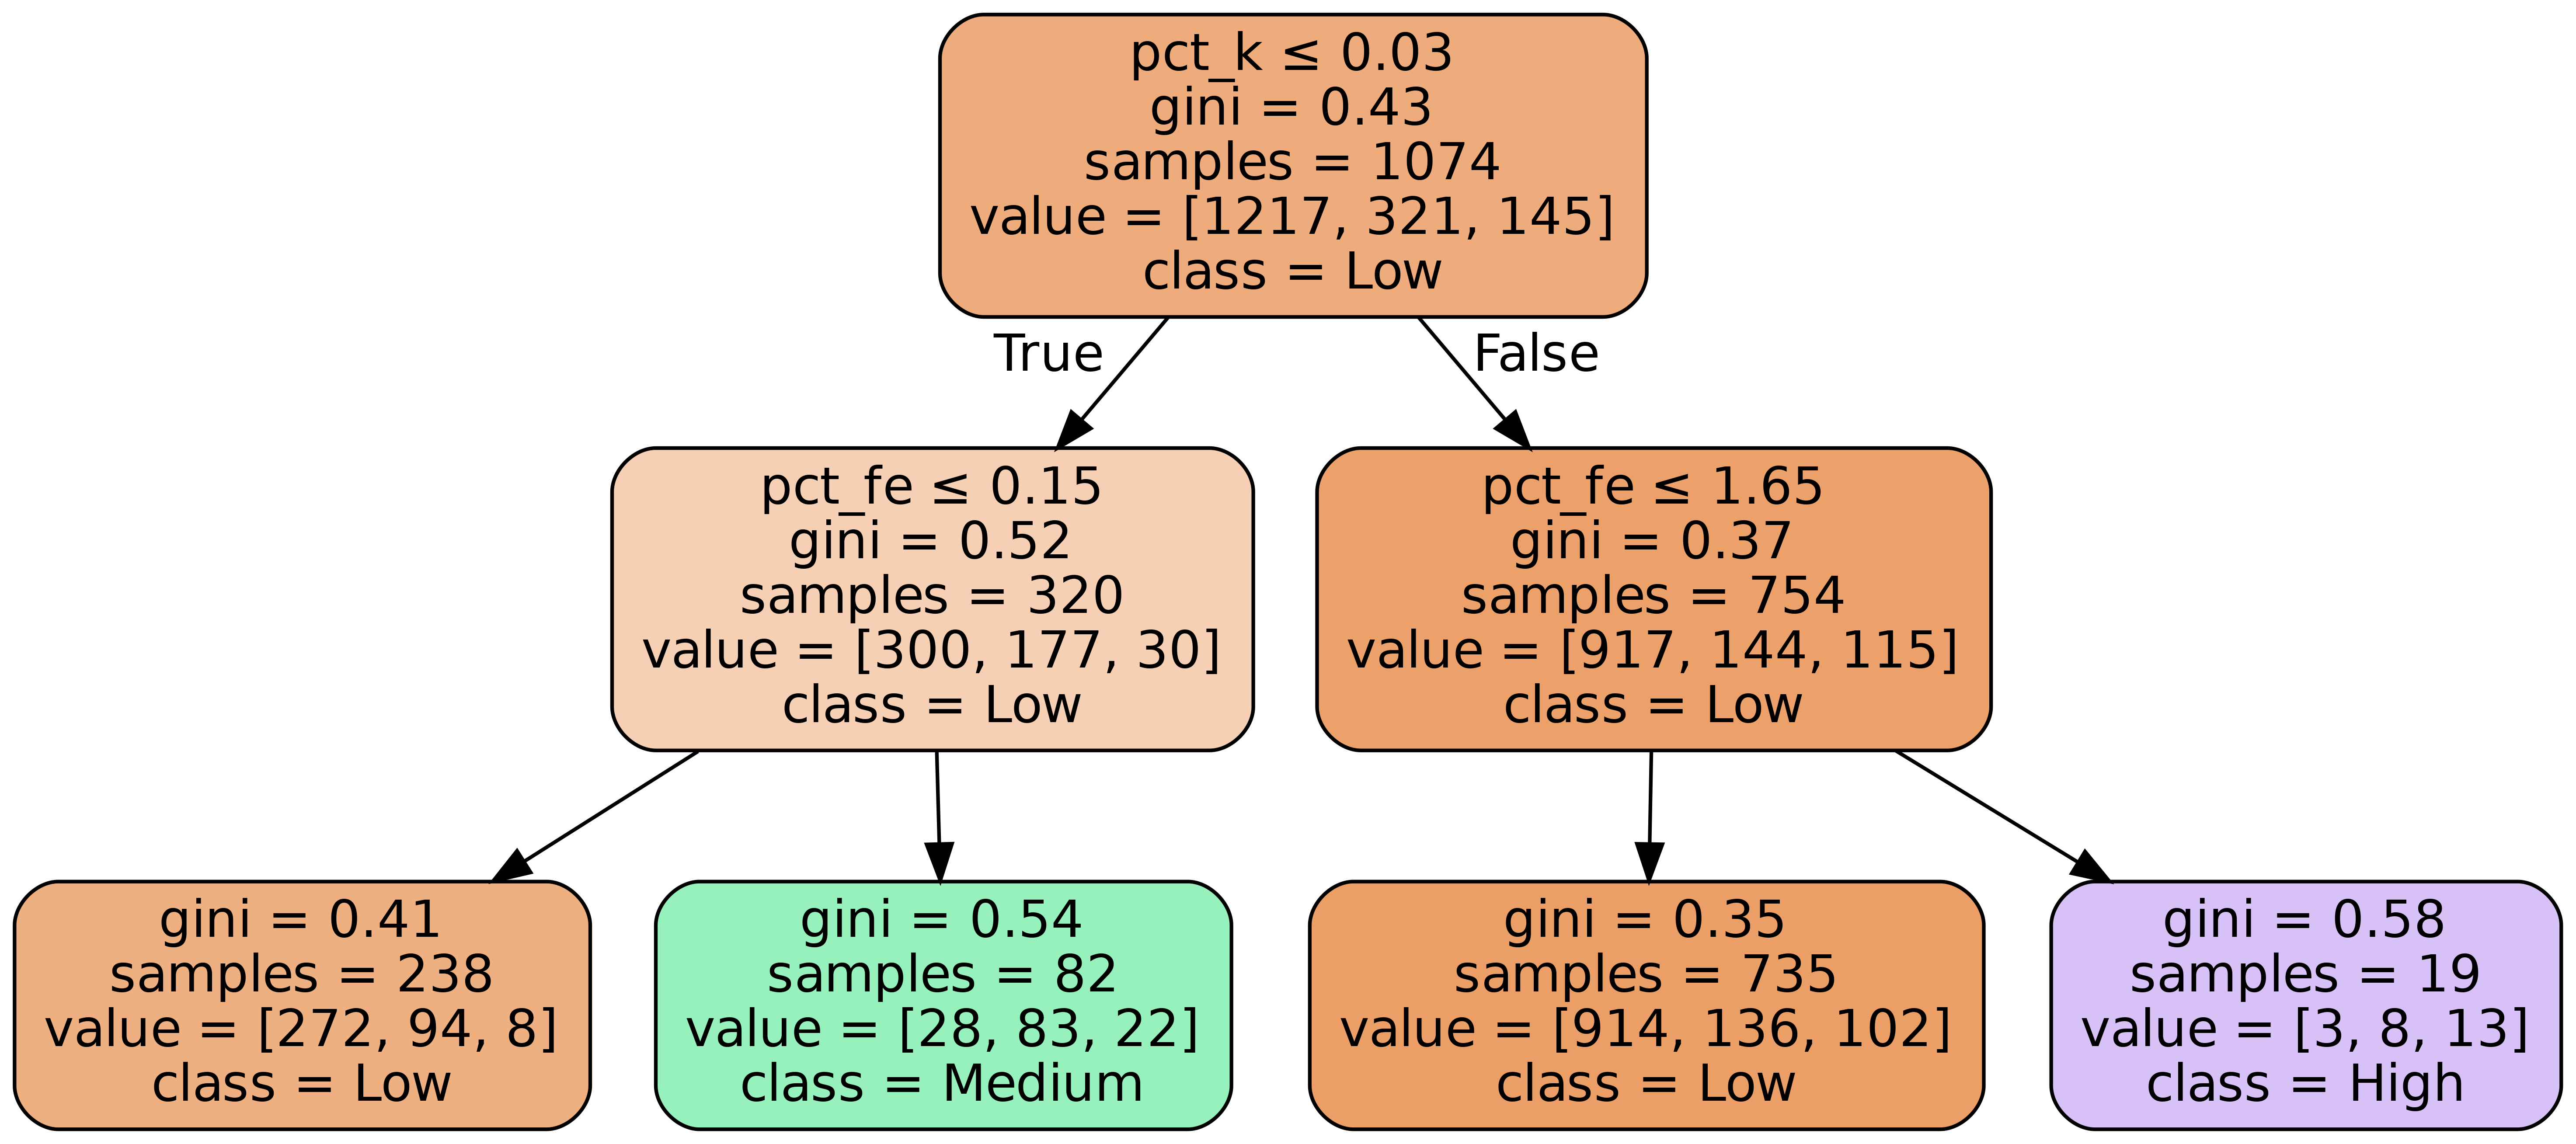

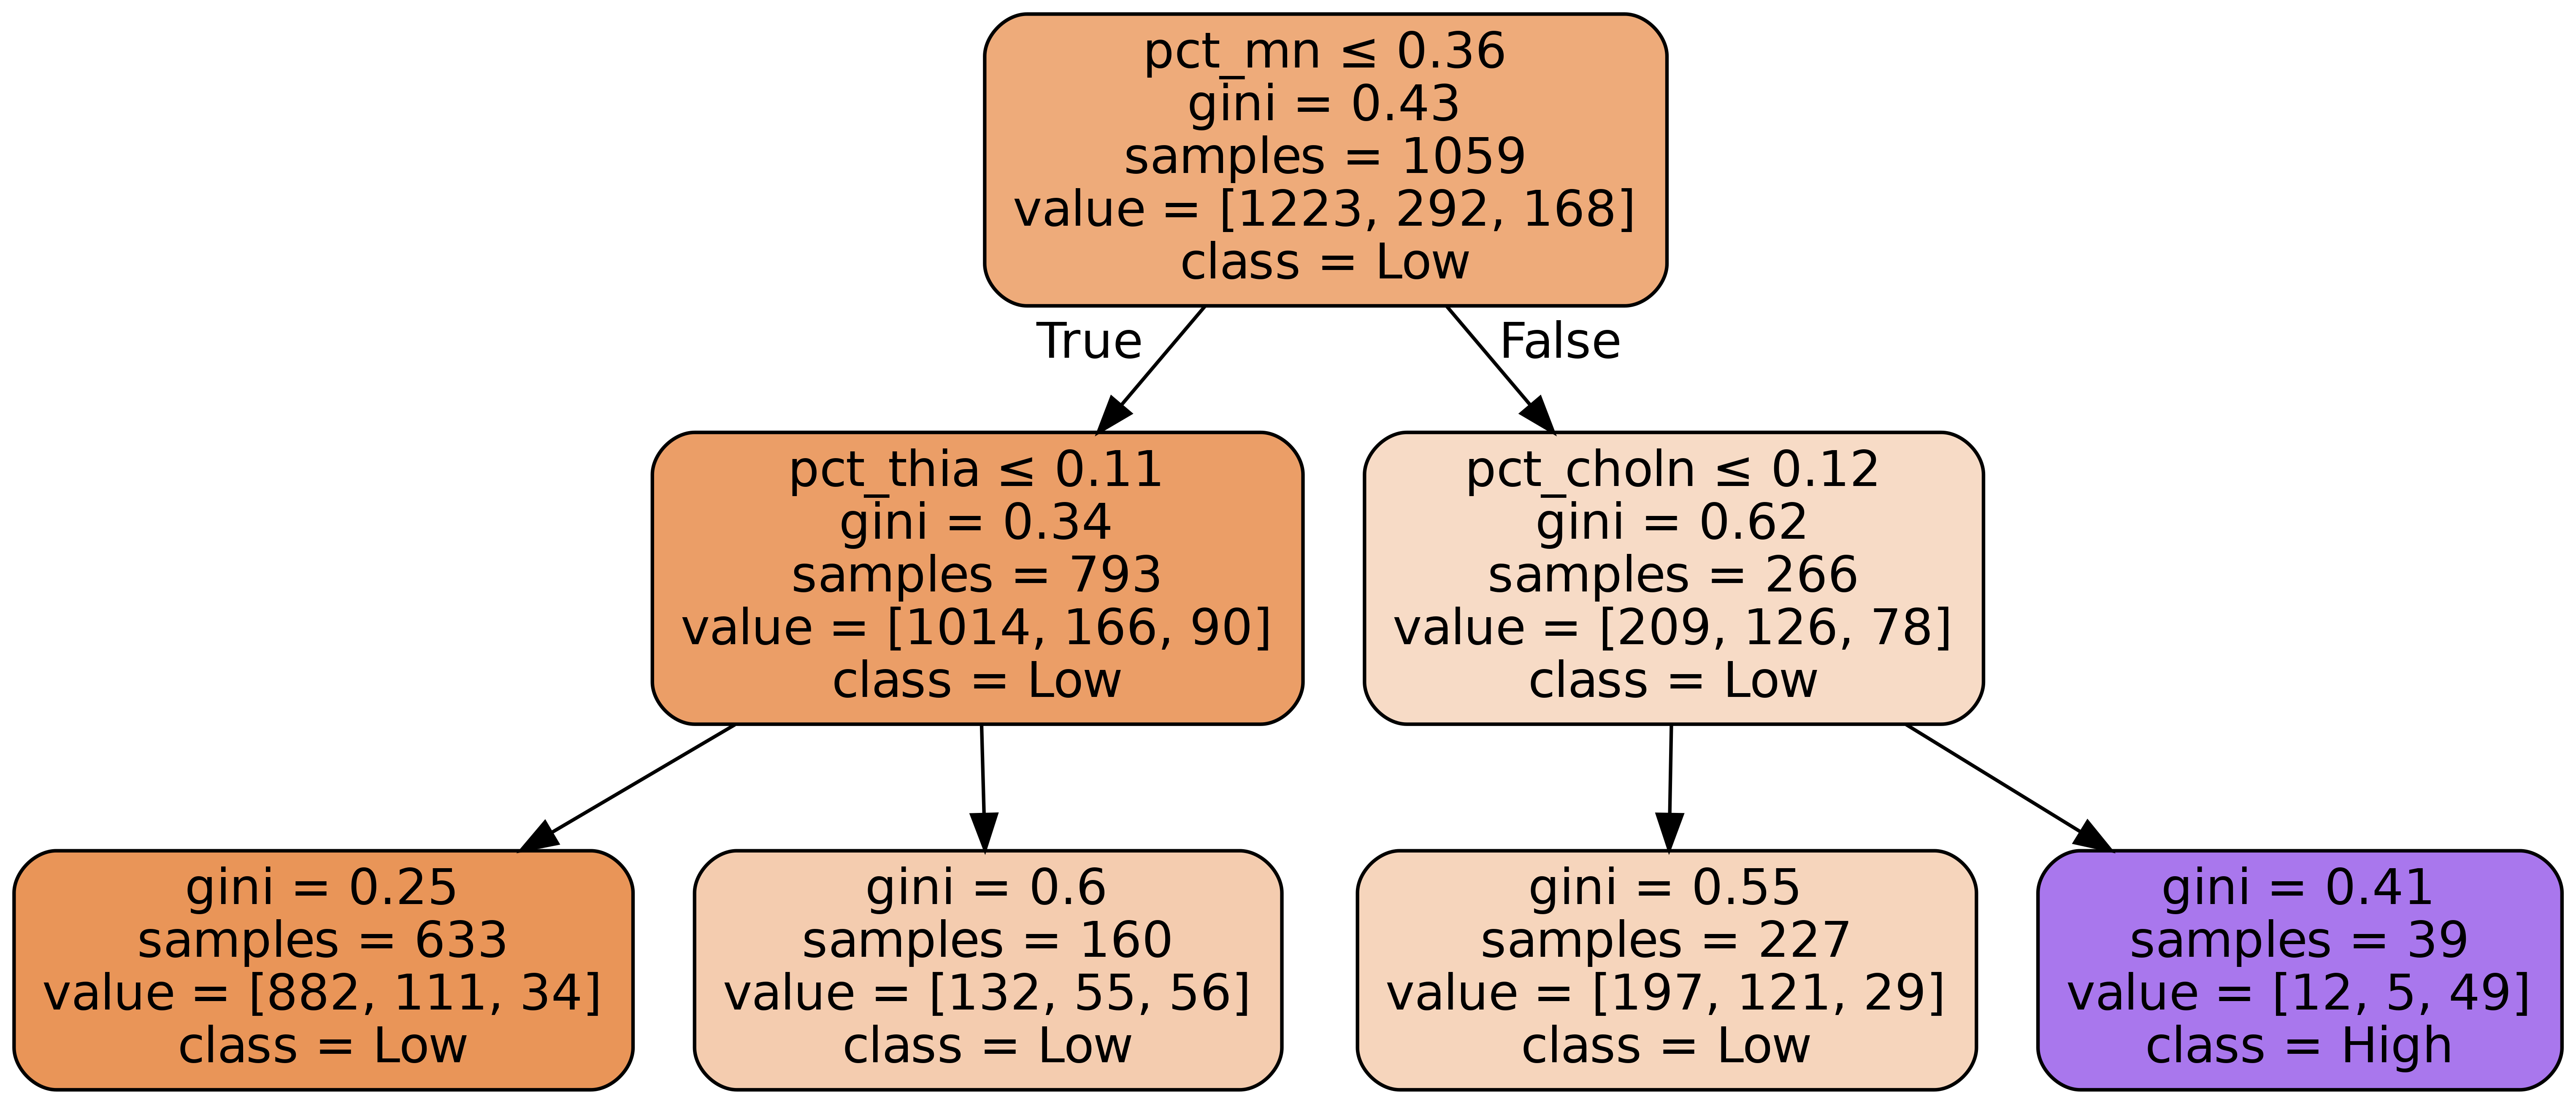

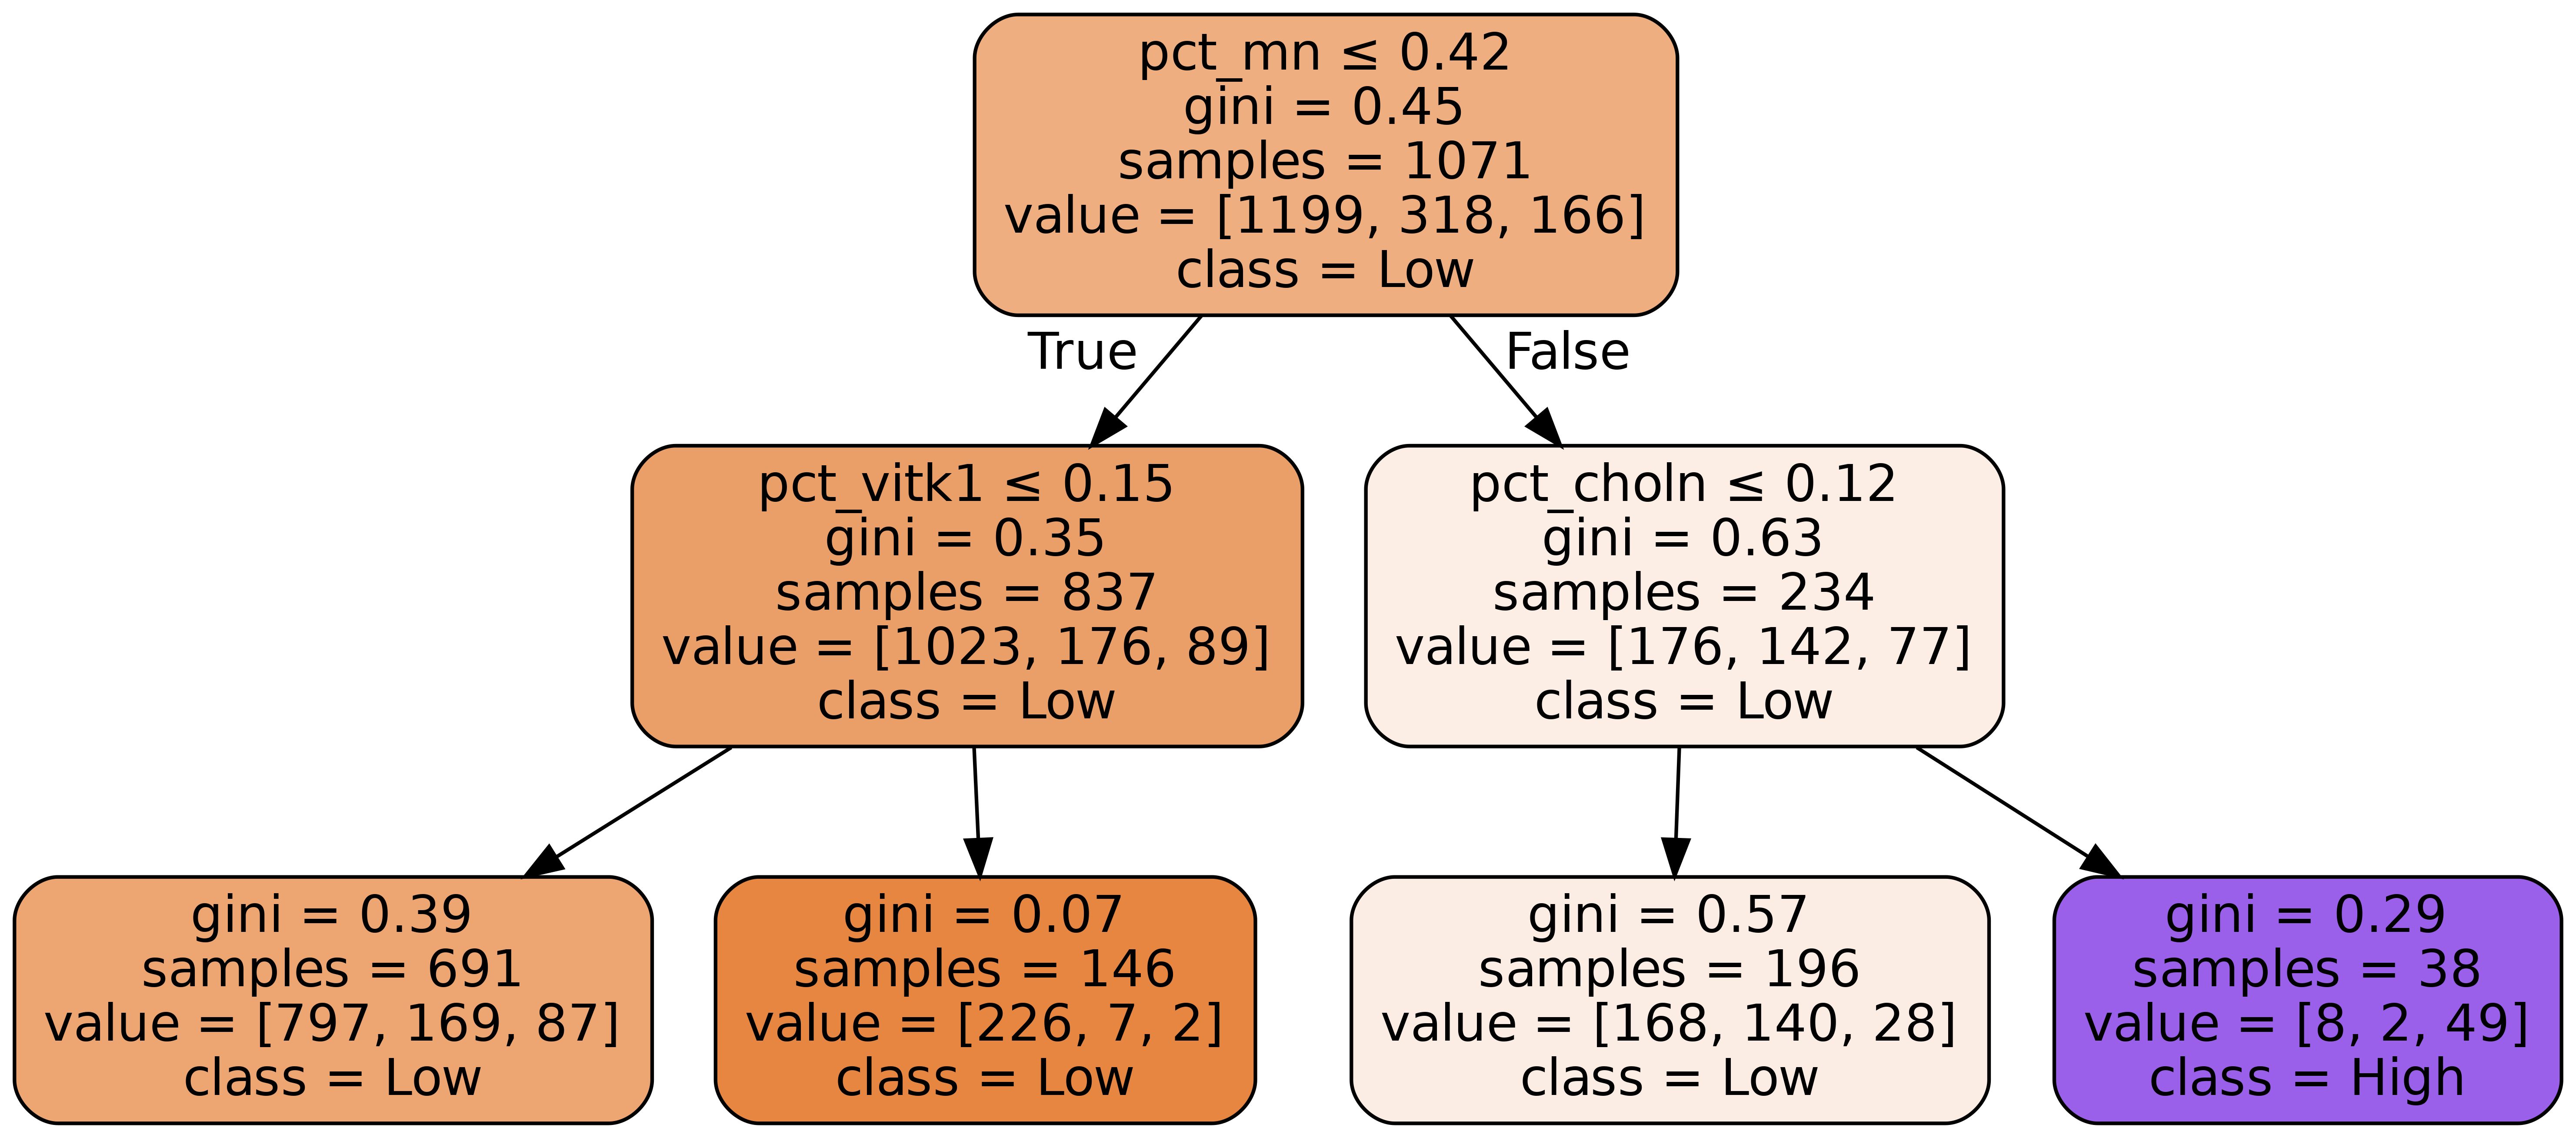

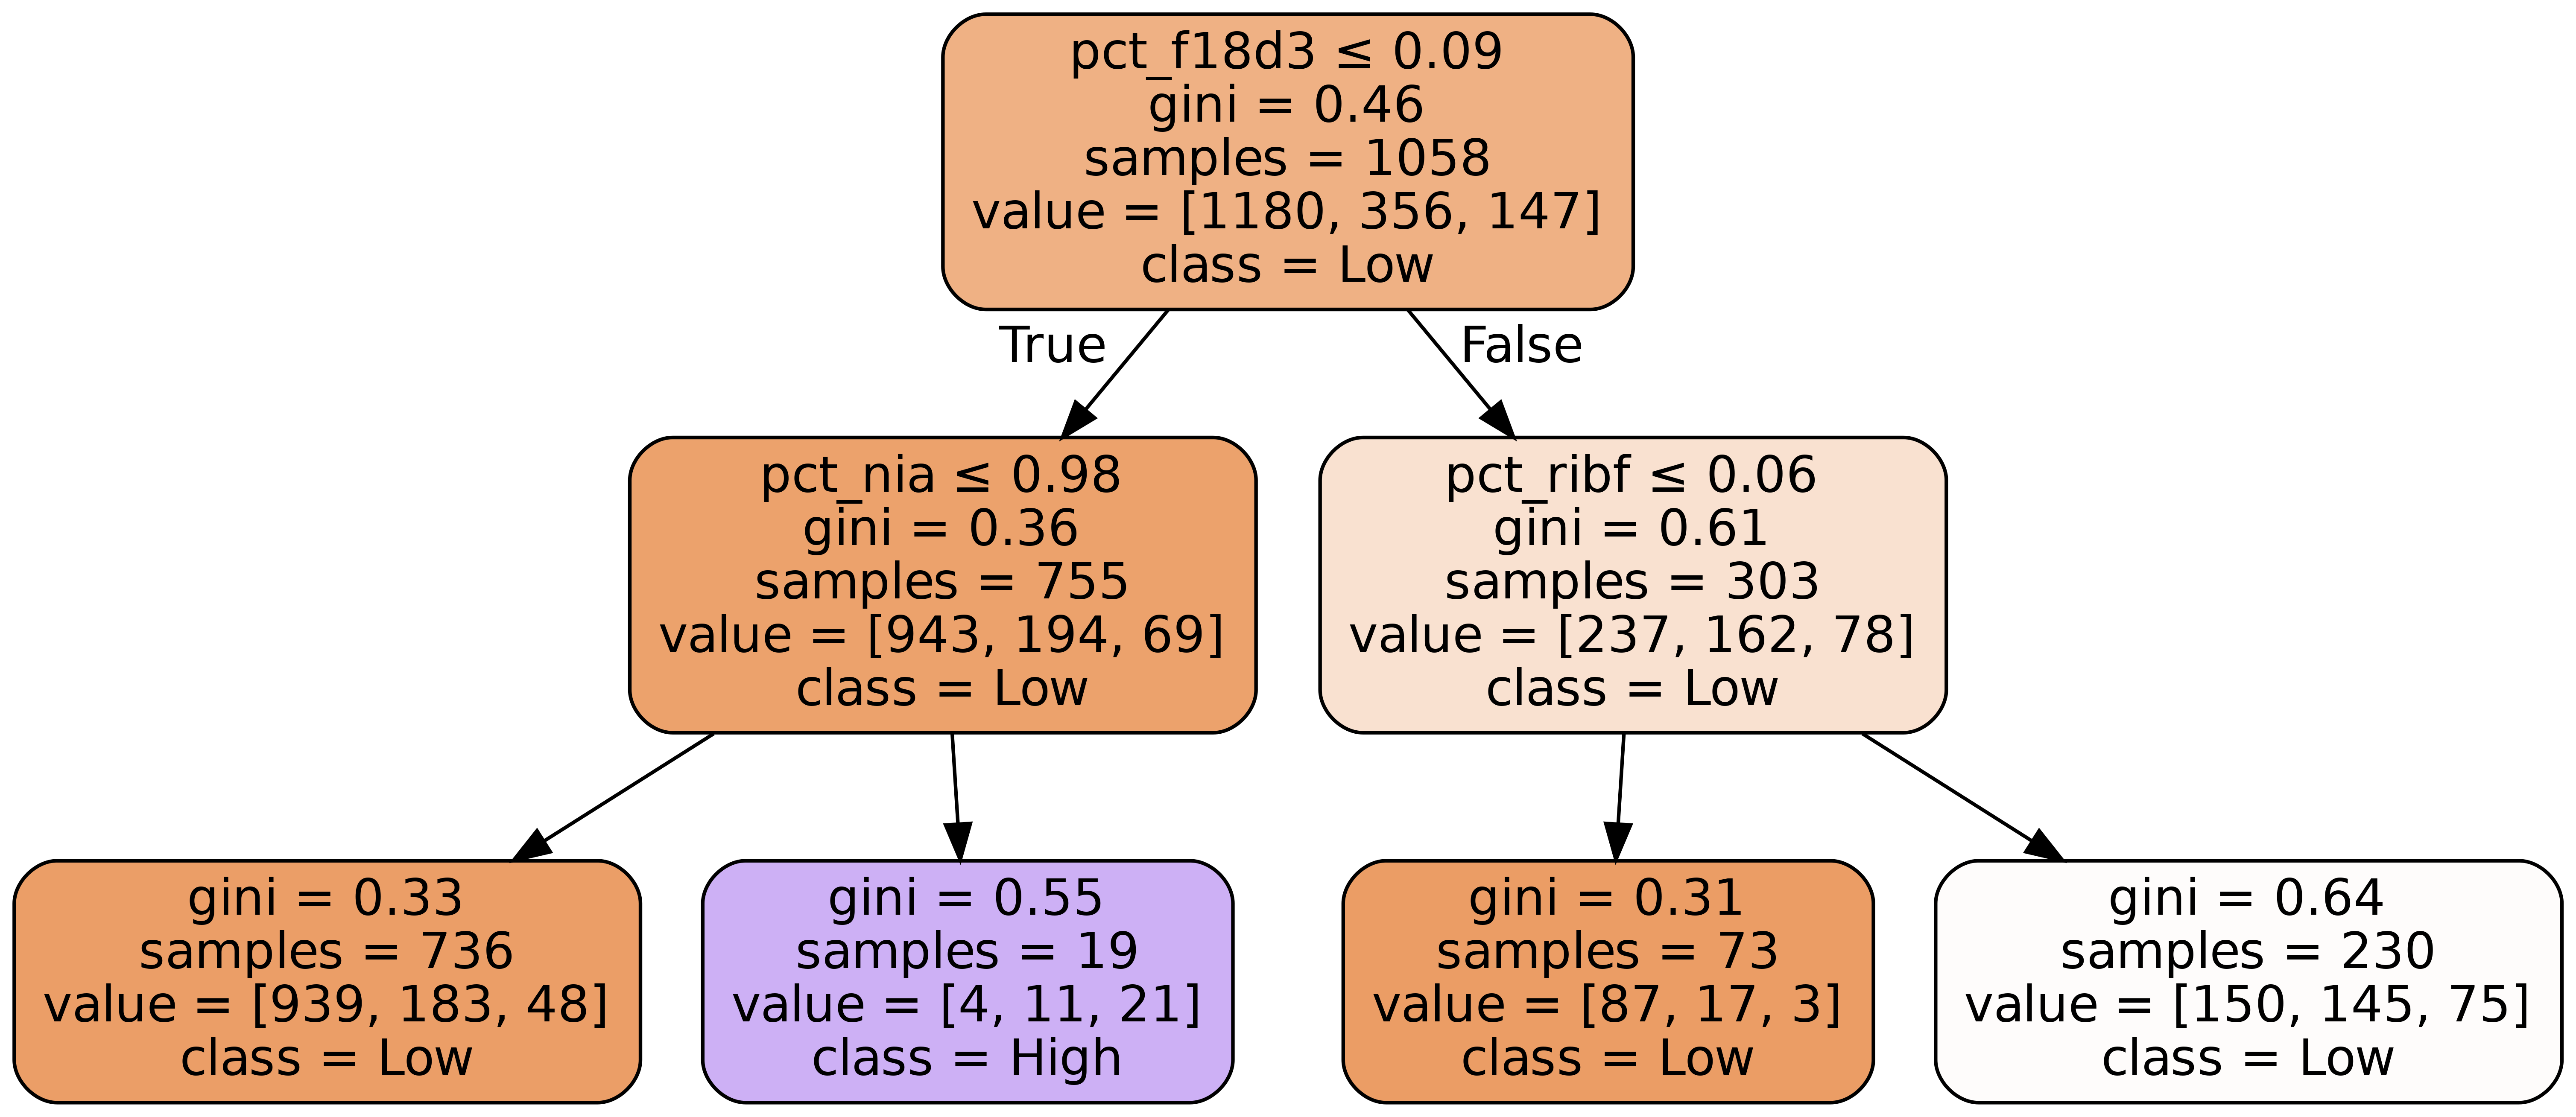

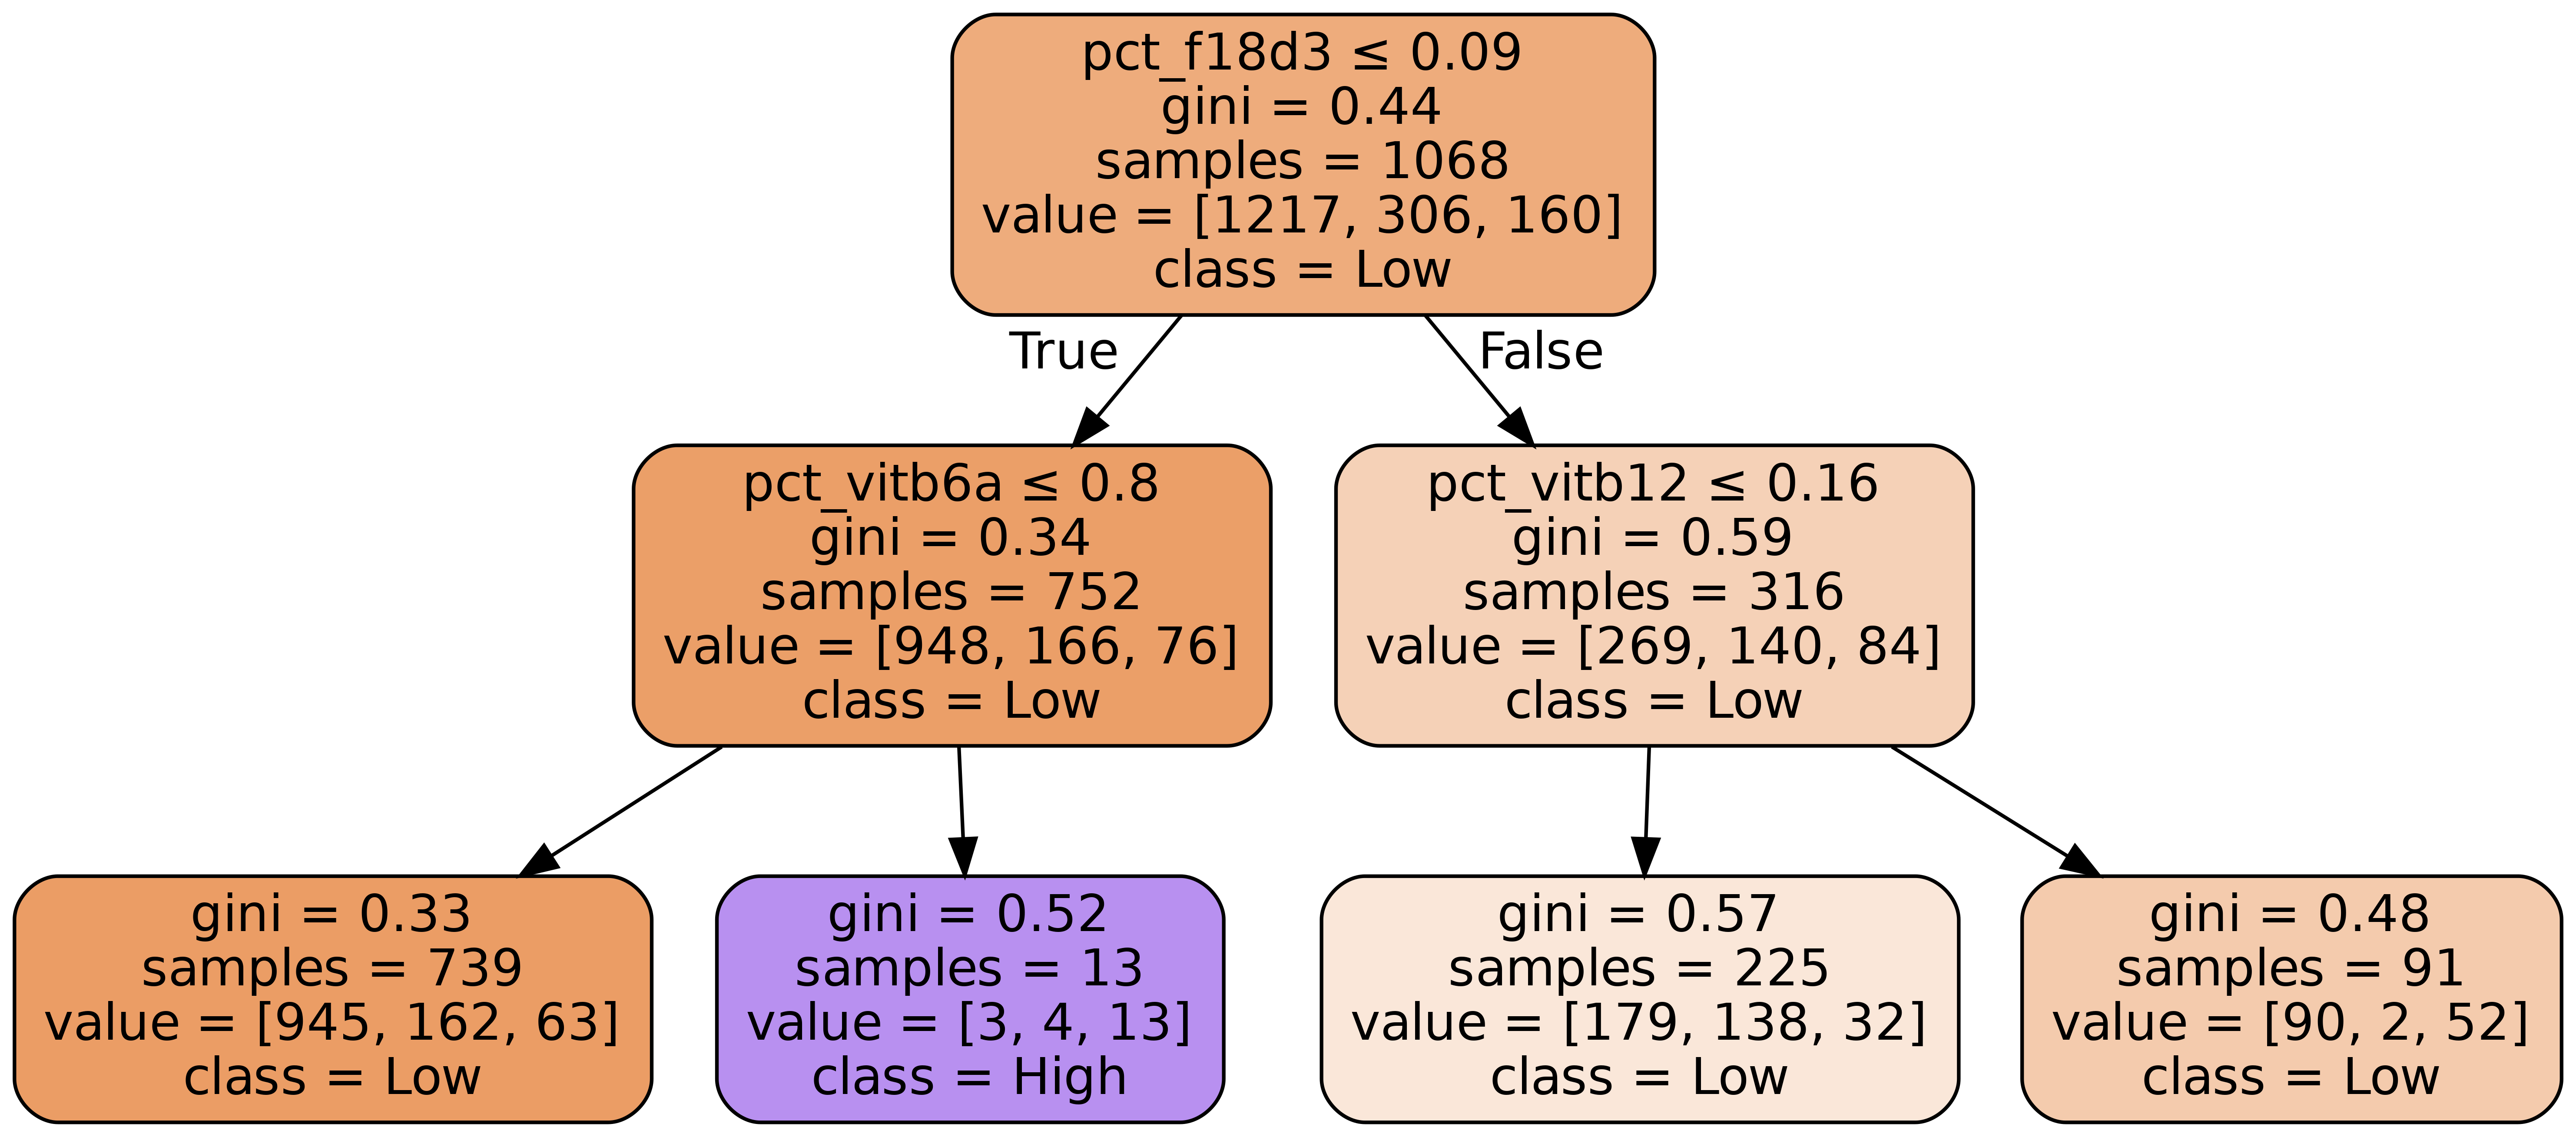

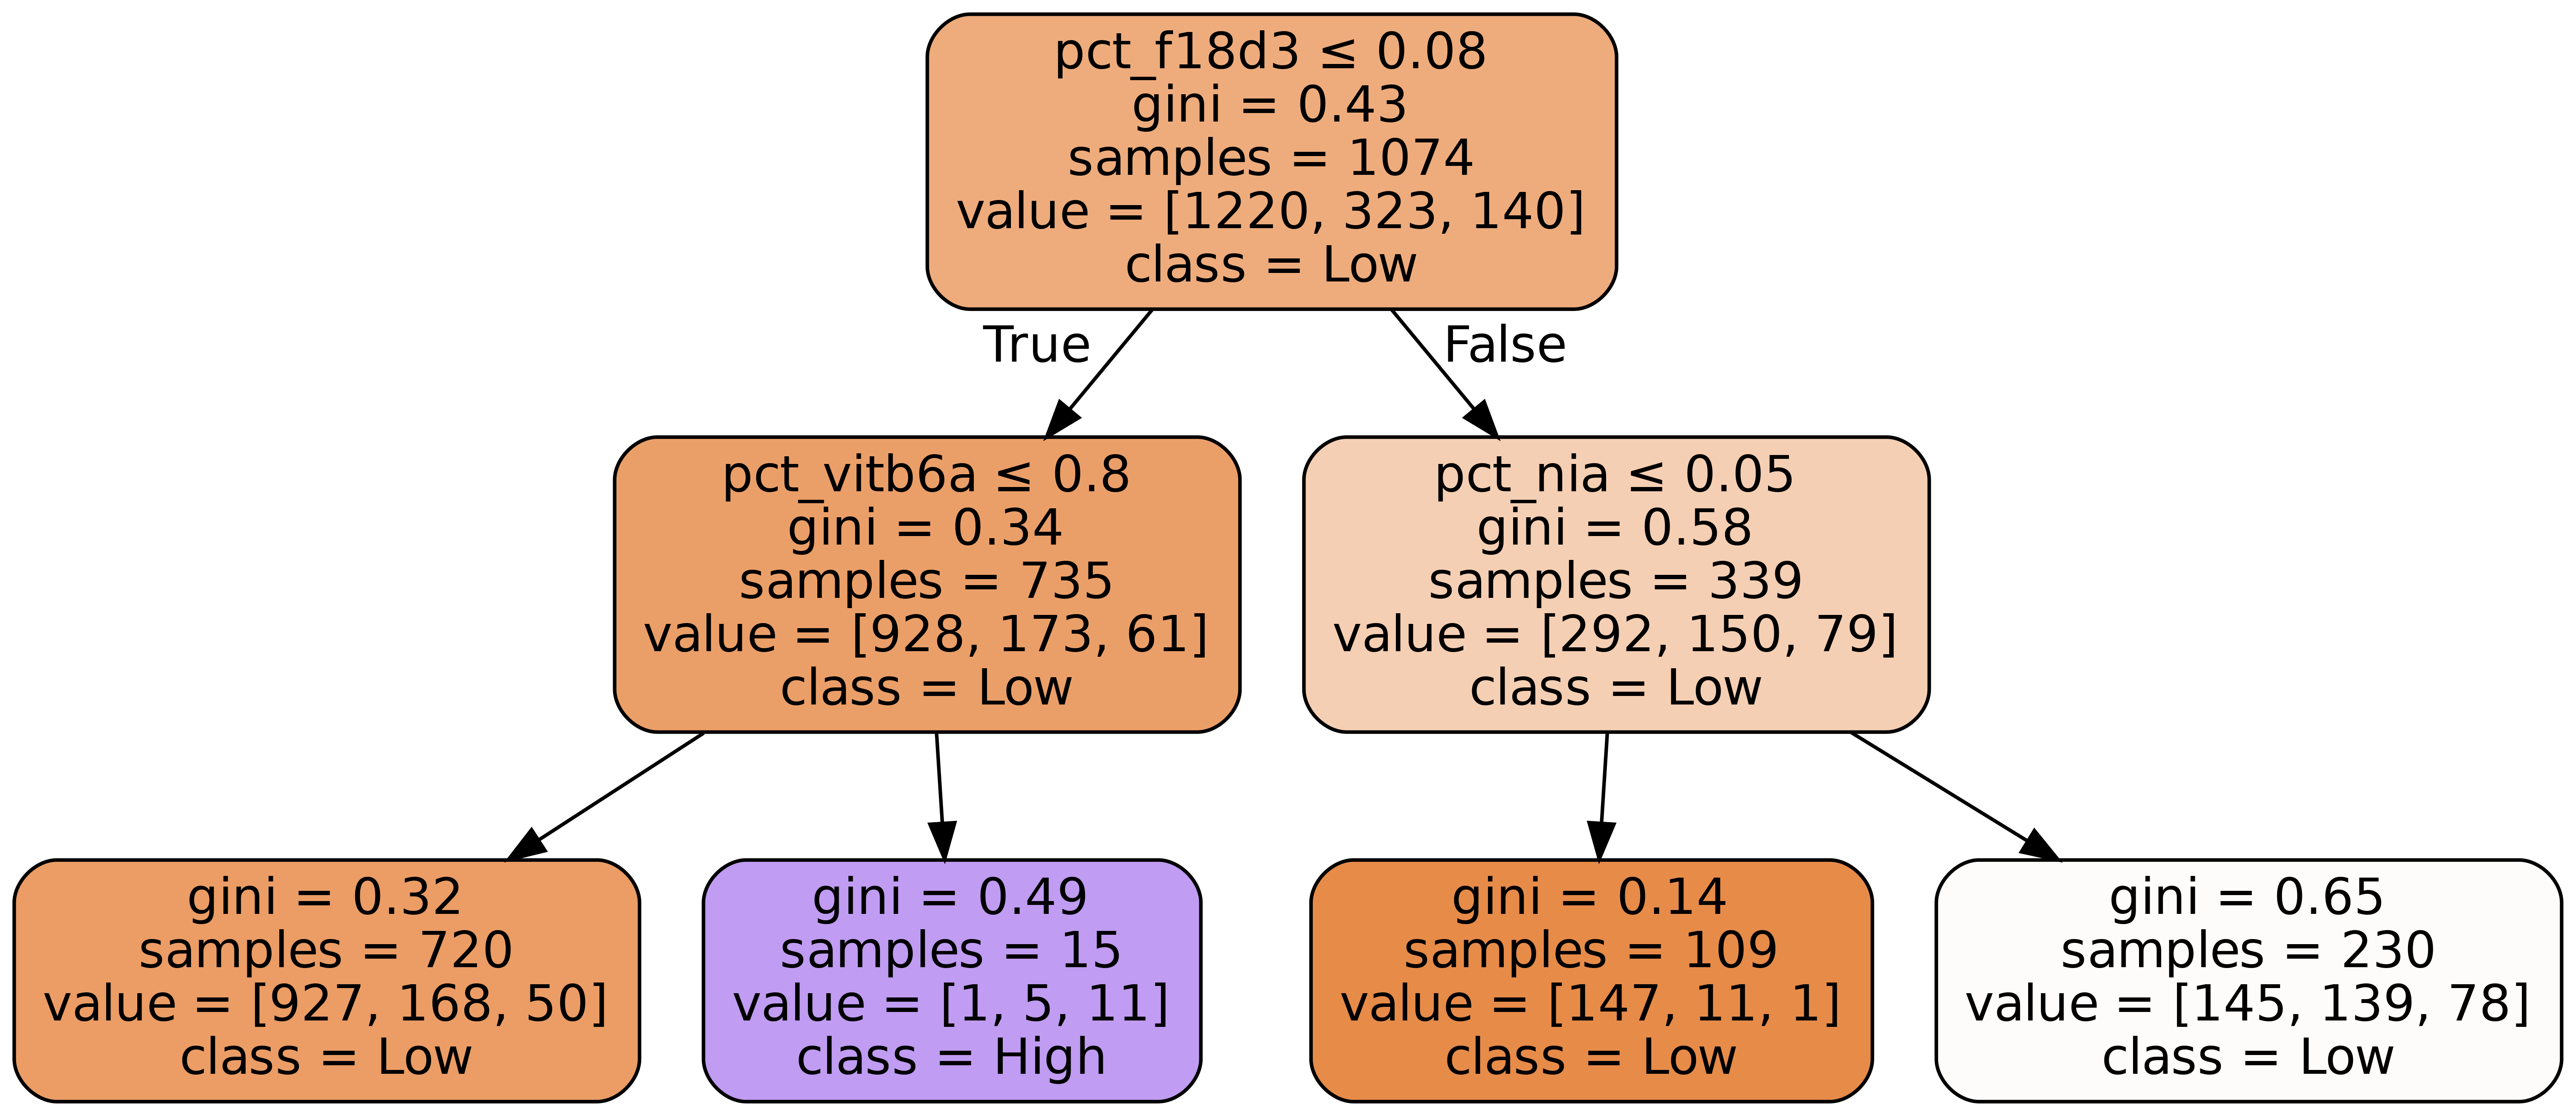

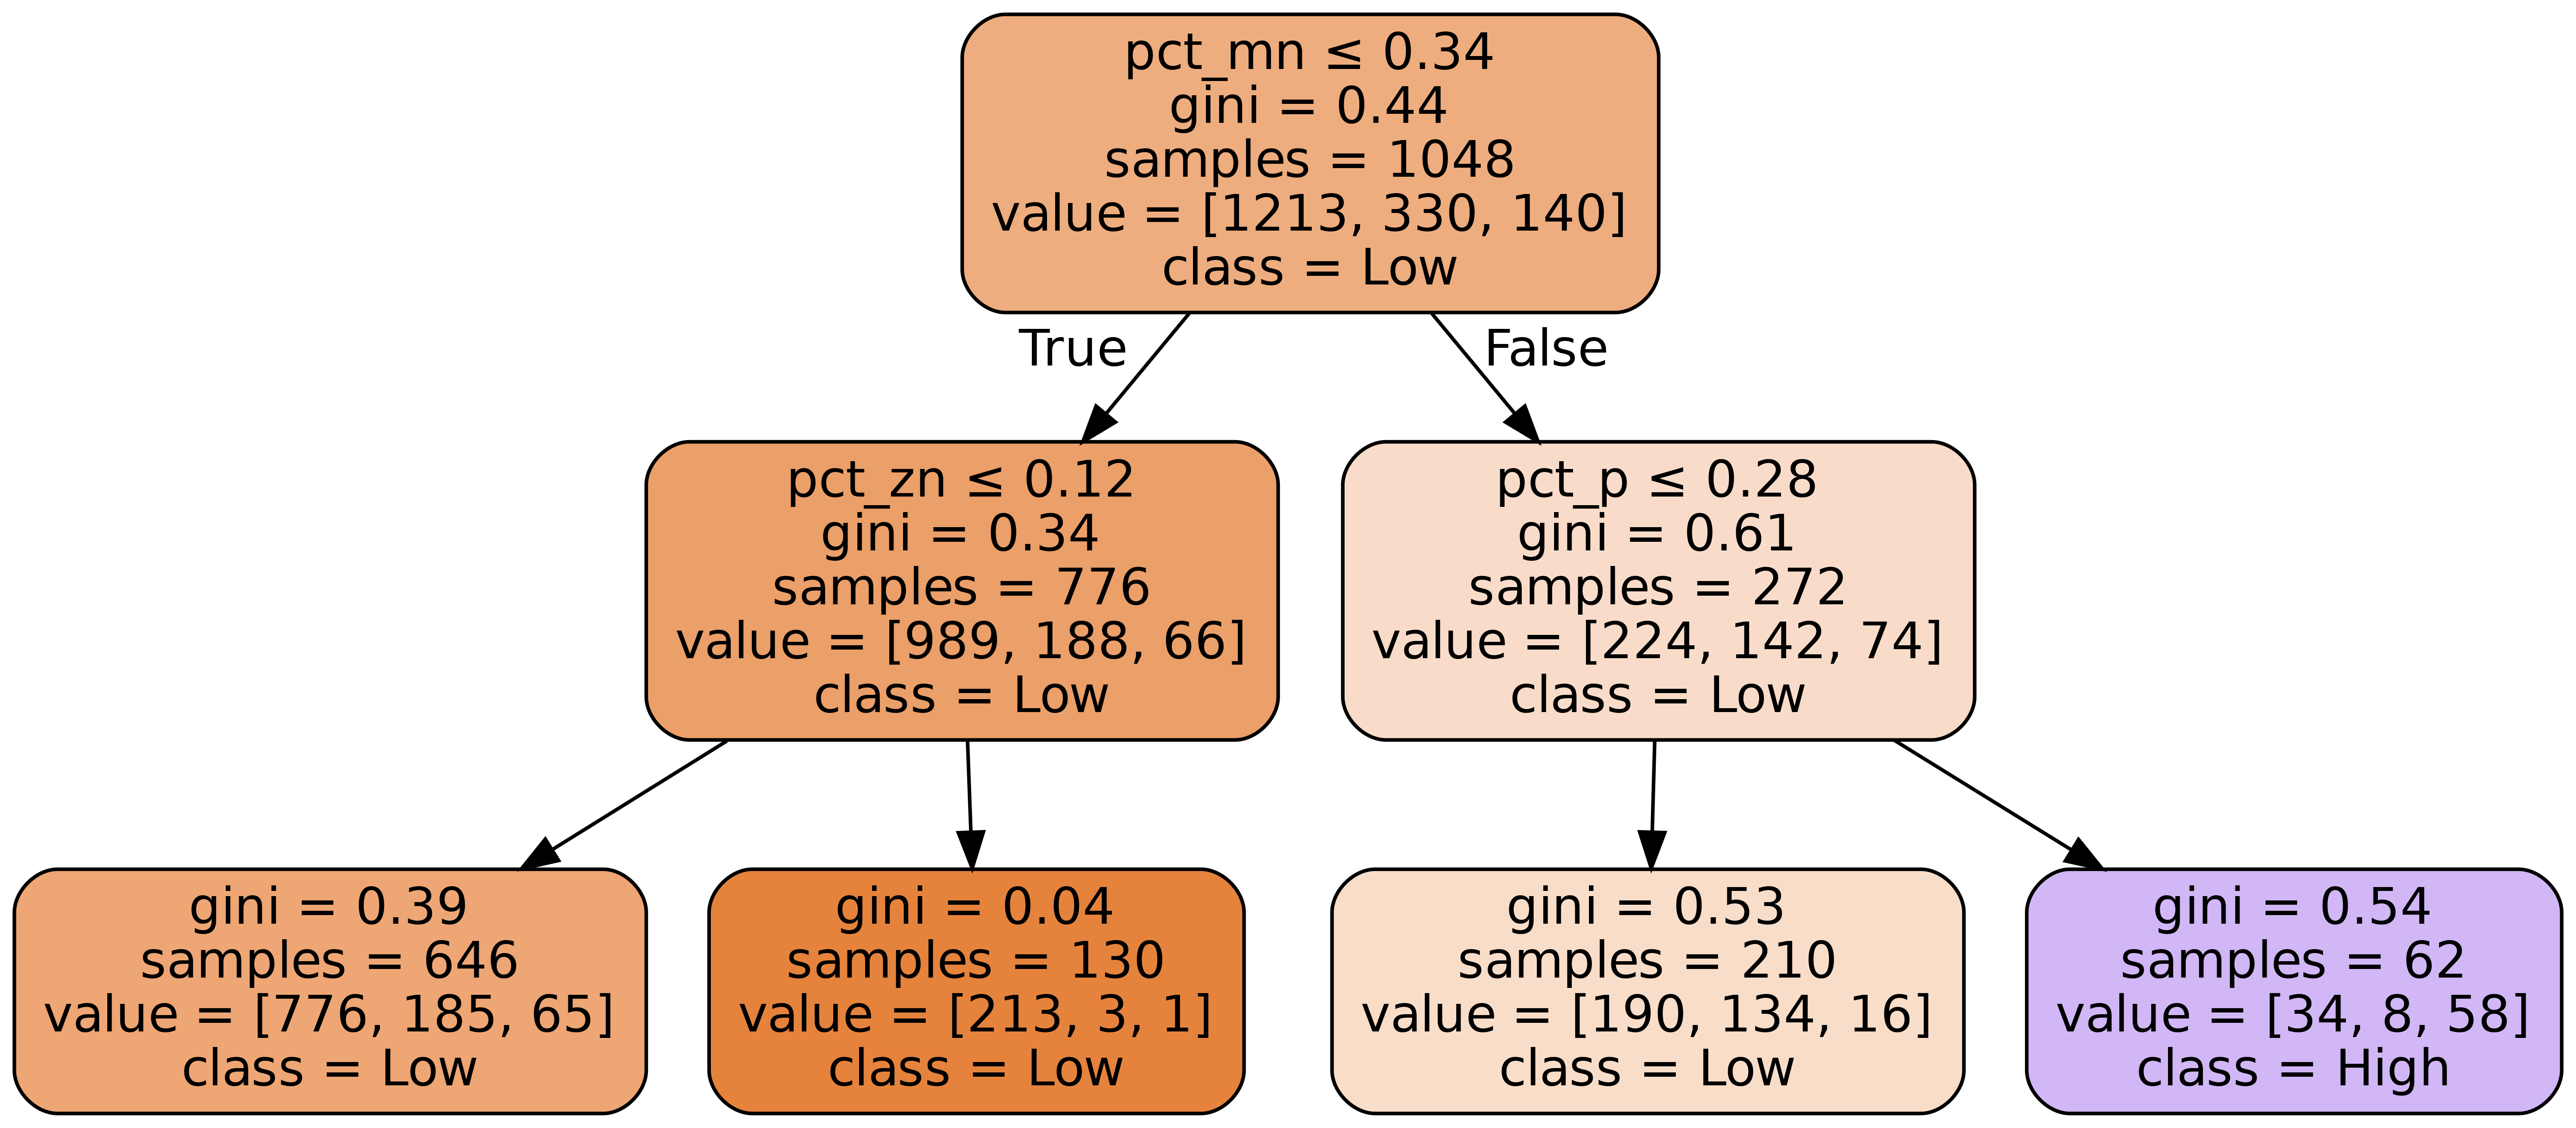

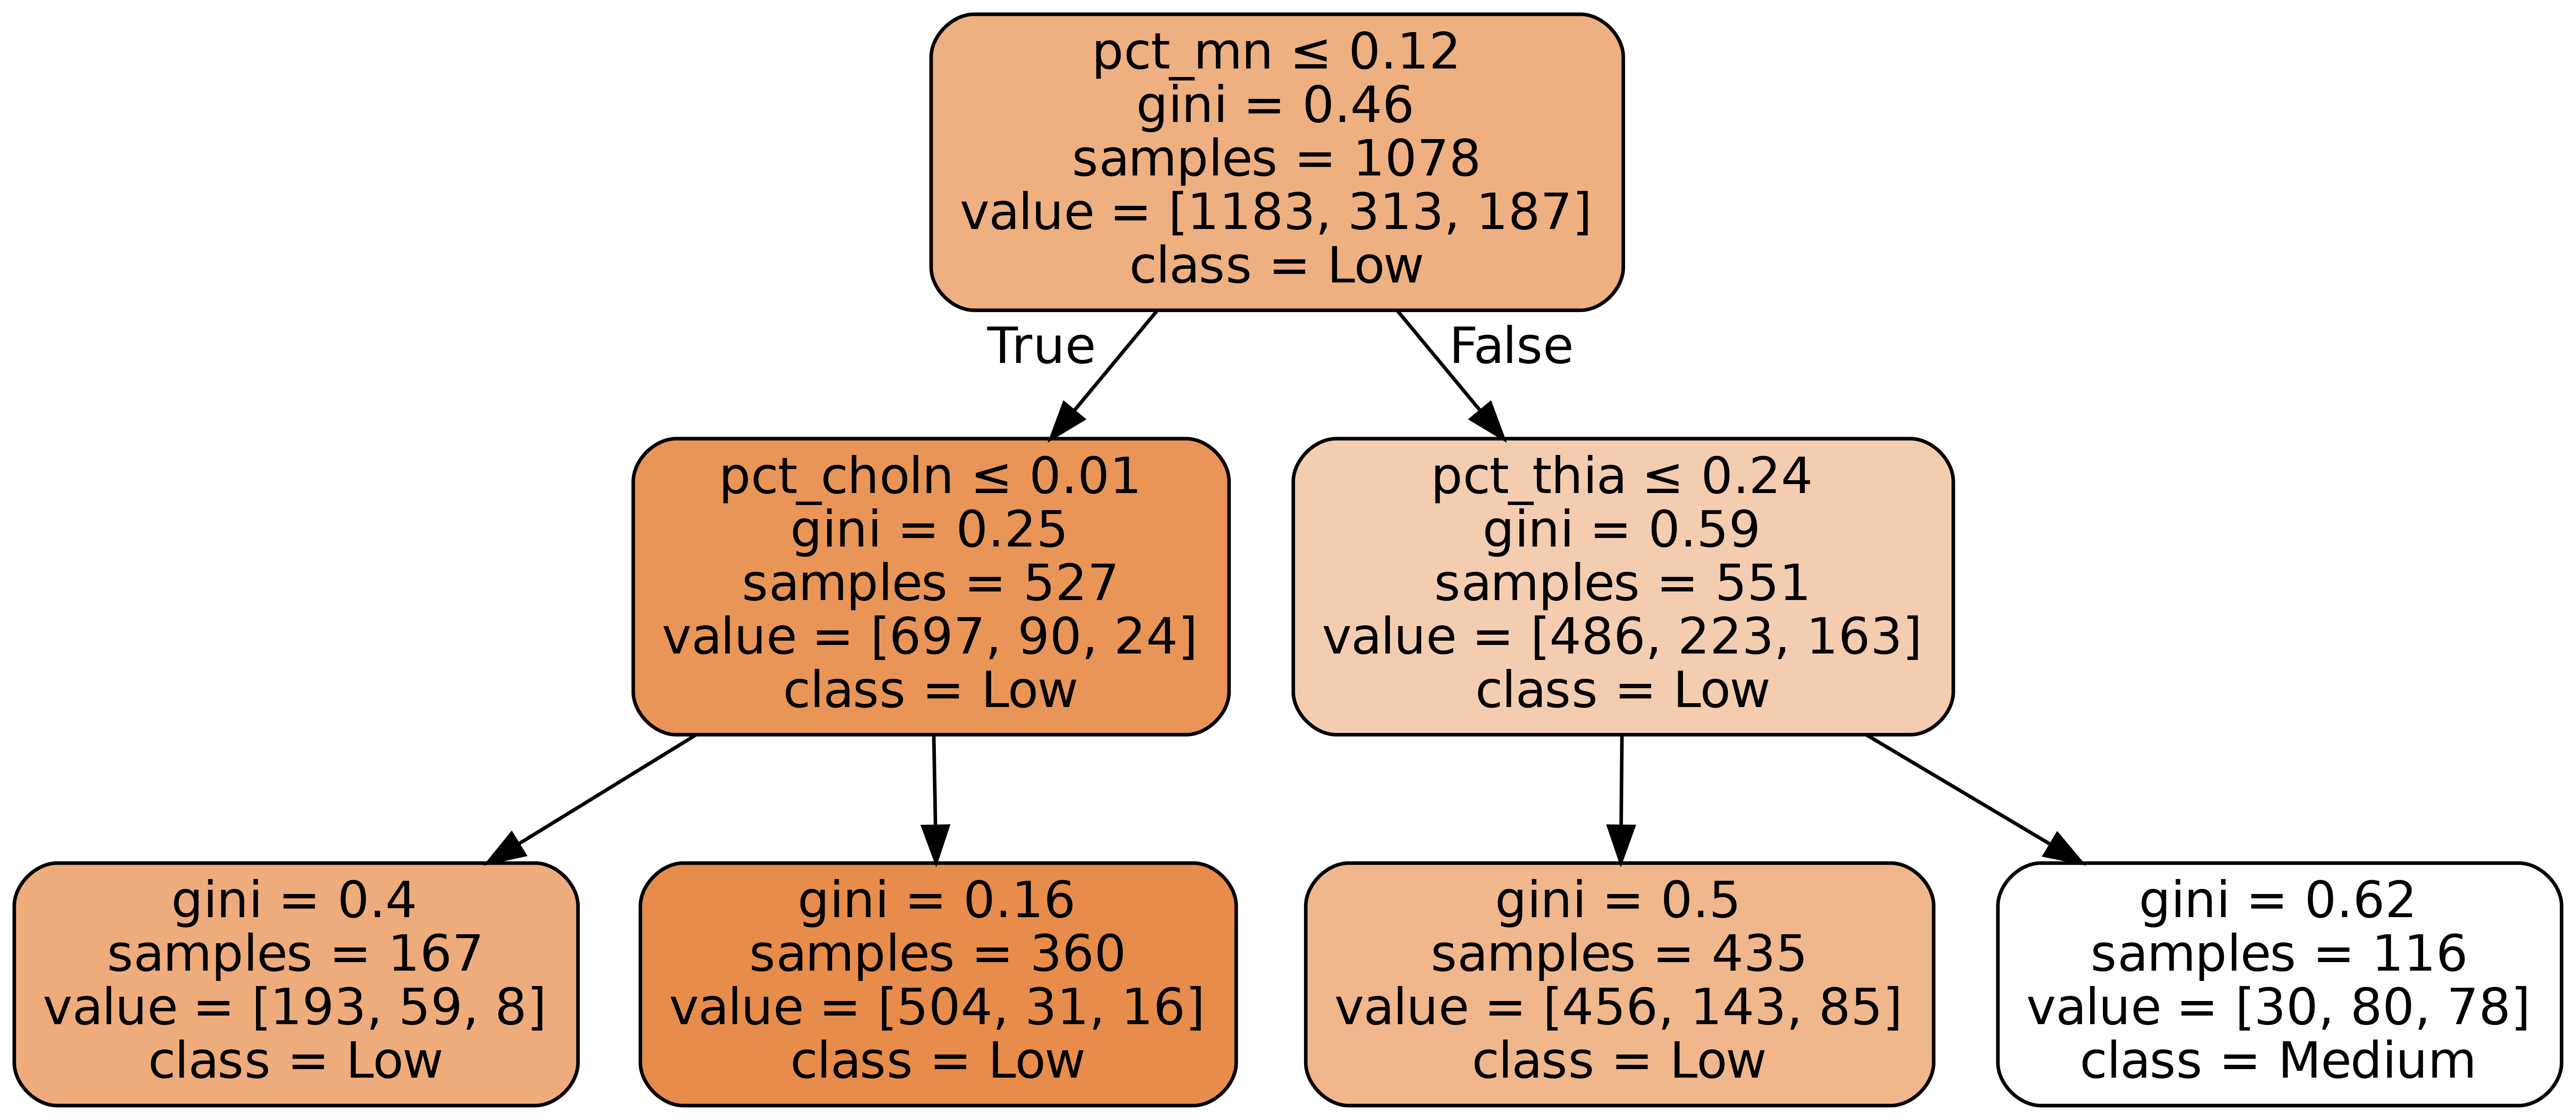

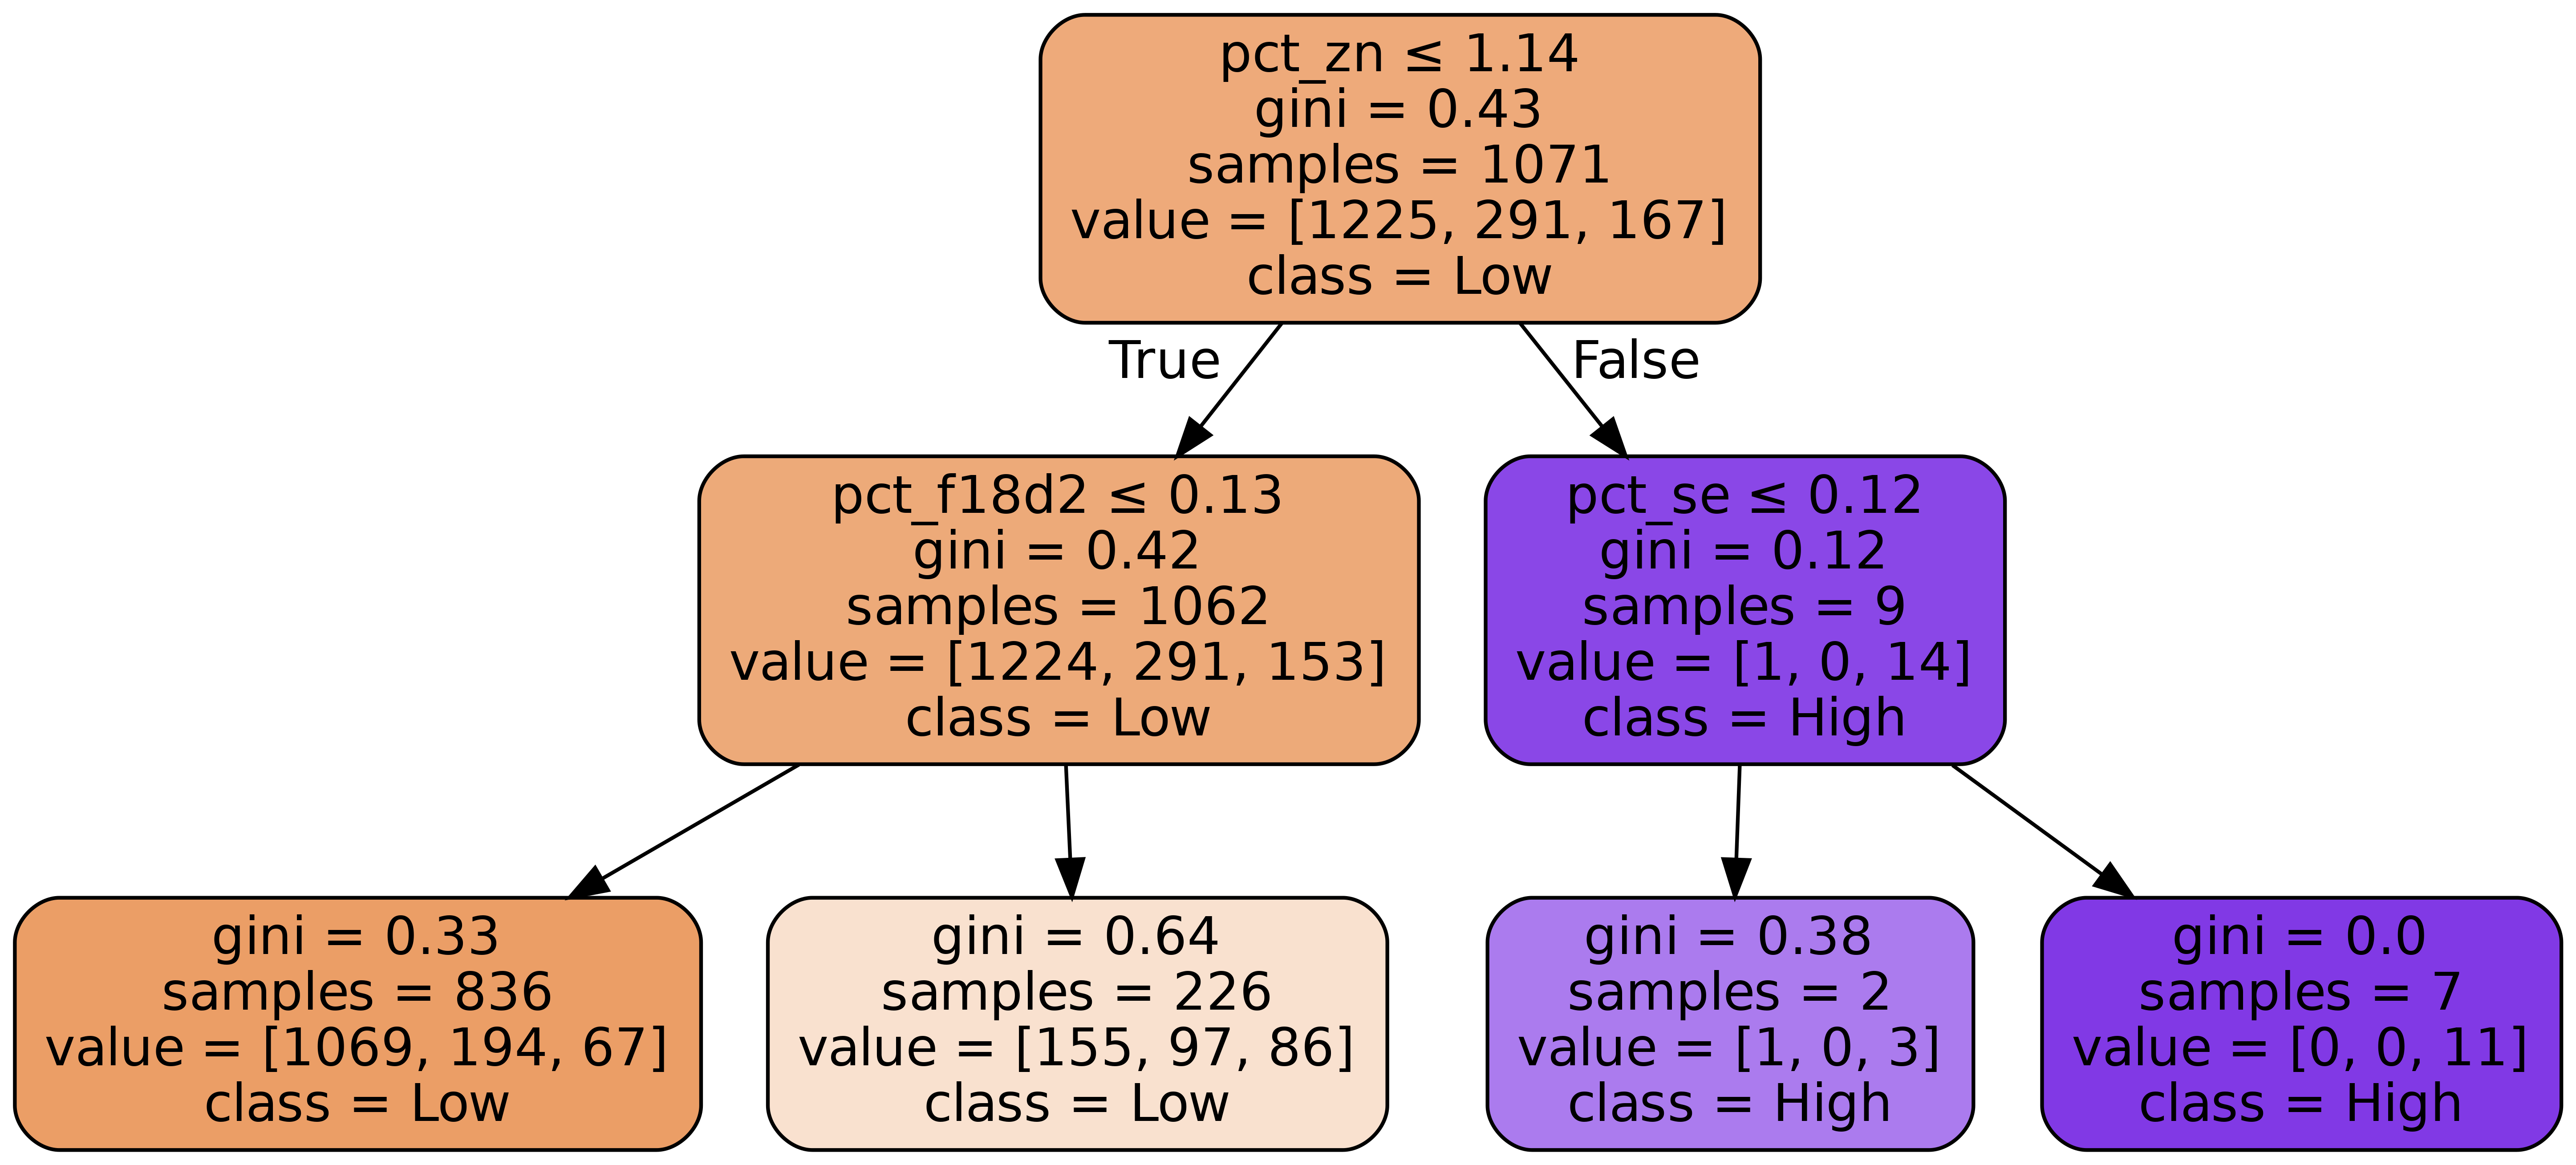

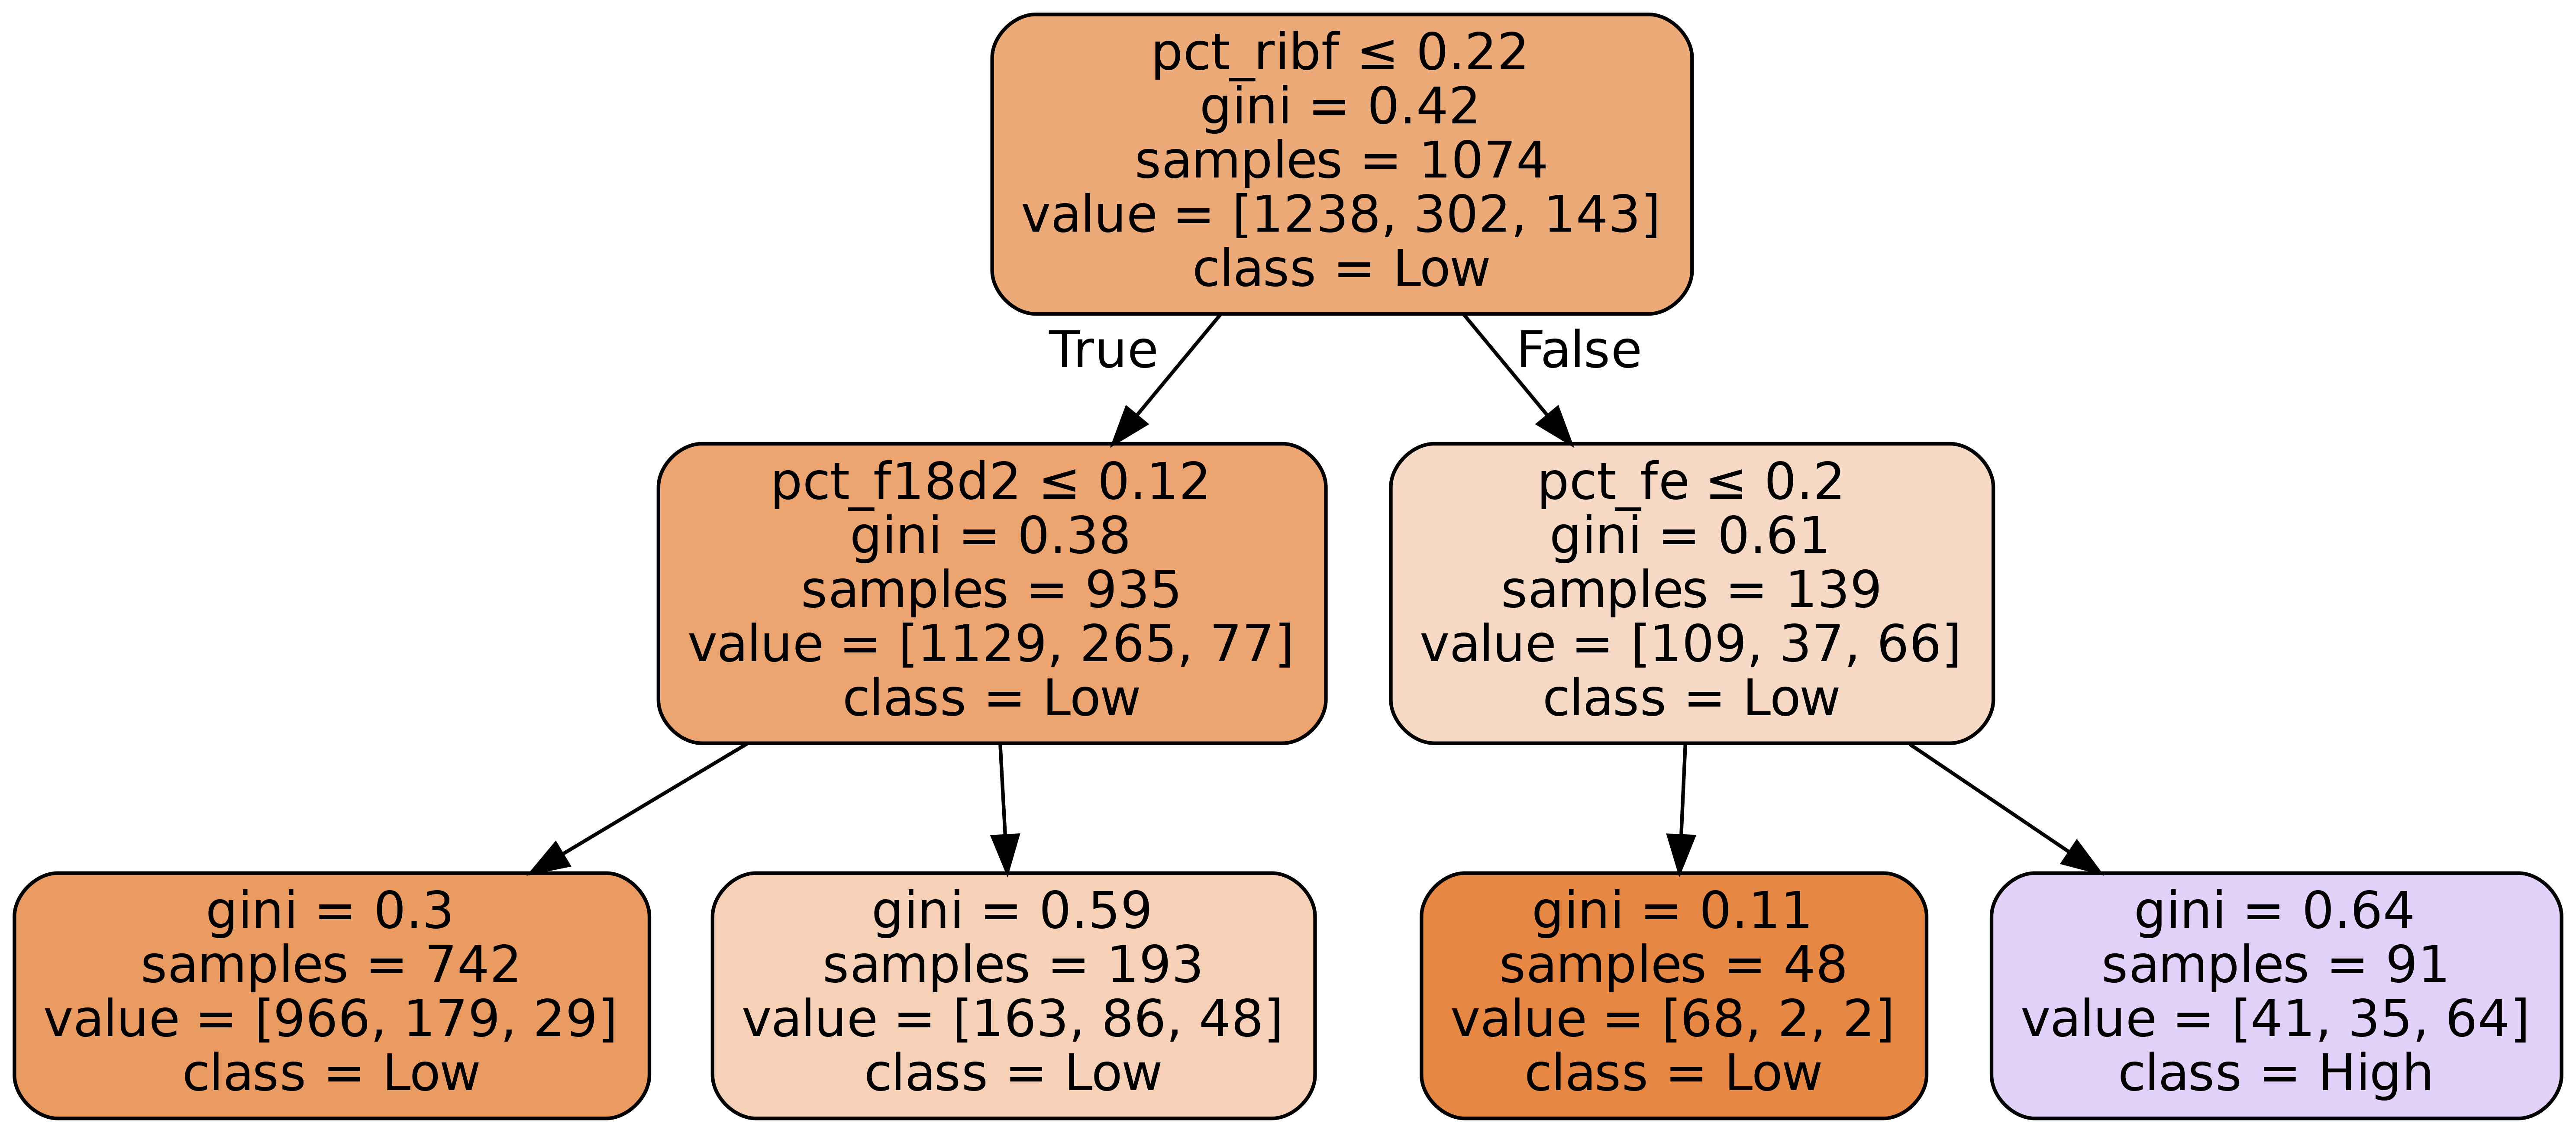

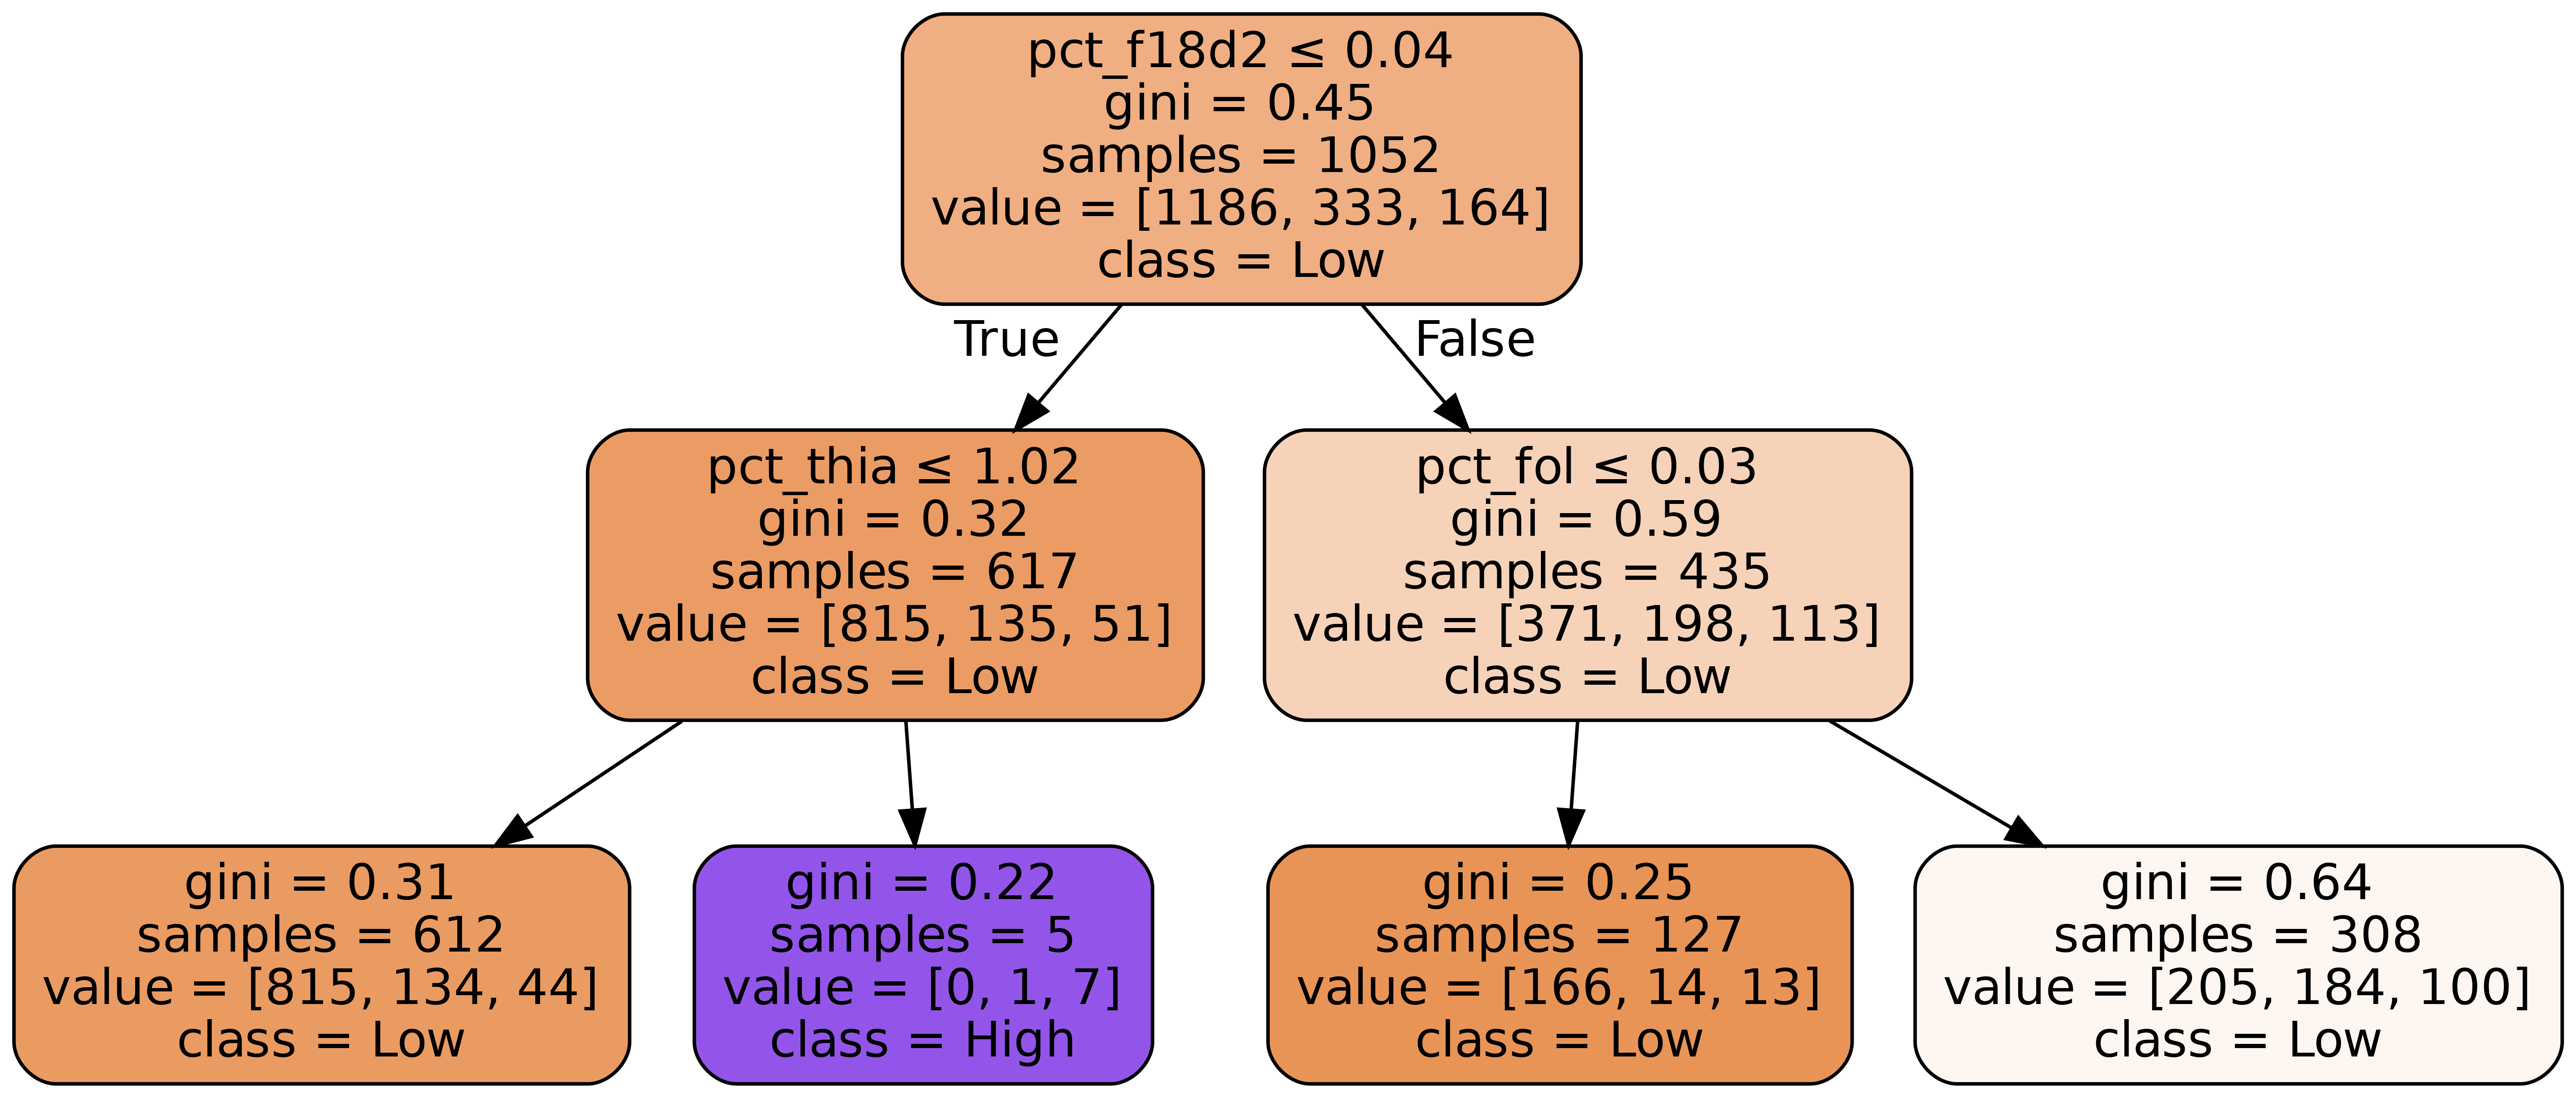

In [14]:
# Visualize the top ten decision trees
images = [graph_tree(tree) for tree in ranked.iloc[:11,0]]
display(*images)